In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import IPython.display
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

np.random.seed(0)

# Import the Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
filepath = "drive/My Drive/Documents/Education/University - 1 - UVA/Coursework - 6 - 2020 Fall/CS 4774 Machine Learning/ML4VA Project/ml4va"

Mounted at /content/drive


In [3]:
# Import data
df0 = pd.read_csv(filepath + "/Virginia_Crashes.csv")
df0.head()

,X,Y,OBJECTID,Document_Nbr,Crash_Dt,Time_Slicing,Weather_Condition,Rte_Nm,Rns_Mp,First_Harmful_Event_of_Entire_C,Speed_Notspeed,Belted_Unbelted,Alcohol_Notalcohol,Rd_Type,Collision_Type,Vehicle_Body_Type_Cd,Driver_Action_Type_Cd,Crash_Severity,K_People,A_People,B_People,C_People,LATITUDE,LONGITUDE,VSP,SYSTEM,OWNERSHIP,CRASH_YEAR,Local_Case_Cd,FAC,FUN,Light_Condition,DIAGRAM,VDOT_District,Node_Info,Ownership_Used,Physical_Juris,Plan_District,Carspeedlimit,Crash_Military_Tm,Crash_Event_Type_Dsc,Rte_Category_Cd,Roadway_Surface_Cond,Vehiclenumber,Driverage,Drivergen,Driverinjurytype,Passage,Pedage,Pedgen,Pedinjurytype,Passgen,Passinjurytype
0,-76.699480,36.827038,1,130015005,2013/01/02 00:00:00+00,6PM TO 9PM,1. No Adverse Condition (Clear/Cloudy),R-VA046SC00606EB,3.840718,14. Ditch,Not_SPEED,BELTED,Not_ALCOHOL,RD-UNKNOWN,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,B.Visible Injury,0,0,1,0,36.827030,-76.699478,5,3,3,2013,201202934,"0.Two-way, non-divided",6.Rural Local,4. Darkness - Road Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,5.Hampton Roads,393039.Deer Path Trl; SC-606E (Isle of Wight C...,VDOT_SEC,46.Isle of Wight,23.Hampton Roads,NaN,2007,14. Ditch,SEC,1. Dry,1,18,Female,B,NaN,NaN,NaN,NaN,NaN,NaN
1,-77.663366,37.609240,2,130015012,2013/01/02 00:00:00+00,0AM TO 3AM,1. No Adverse Condition (Clear/Cloudy),R-VA SR00288NB,28.361159,23. Animal,Not_SPEED,BELTED,Not_ALCOHOL,NOT-RD,10. Deer,22. Truck - Sport Utility Vehicle (SUV),1. No Improper Action,C.Nonvisible Injury,0,0,0,1,37.609232,-77.663364,1,2,2,2013,DIV113000009,"3.Divided, full control of access",7.Rural Principal Arterial - Other Freeways an...,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,4.Richmond,NaN,VDOT_PRI,37.Goochland,15.Richmond Regional,65.0,45,23. Animal,STPRI,1. Dry,1,50,Female,C,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.067566,37.499473,3,130015020,2013/01/02 00:00:00+00,0AM TO 3AM,1. No Adverse Condition (Clear/Cloudy),R-VA US00029NB,83.336520,23. Animal,Not_SPEED,BELTED,Not_ALCOHOL,NOT-RD,10. Deer,2. Truck - Pick-up/Passenger Truck,1. No Improper Action,PDO.Property Damage Only,0,0,0,0,37.499465,-79.067563,3,2,2,2013,2013-000014,"3.Divided, full control of access",B.Urban Freeways and Expressways; Connecting L...,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,3.Lynchburg,125036.US-29S;Ramp Intersection,VDOT_PRI,5.Amherst,11.Region 2000 Regional,70.0,148,23. Animal,USPRI,1. Dry,1,35,Male,PDO,NaN,NaN,NaN,NaN,NaN,NaN
3,-78.845314,38.453040,4,130015021,2013/01/02 00:00:00+00,3AM TO 6AM,1. No Adverse Condition (Clear/Cloudy),R-VA115UR04110EB,1.501908,4. Fence Or Post,Not_SPEED,BELTED,Not_ALCOHOL,RD-UNKNOWN,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,PDO.Property Damage Only,0,0,0,0,38.453032,-78.845311,2,9,6,2013,2013-000073,"0.Two-way, non-divided",I.Urban Collector,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,8.Staunton,587178.Blue Ridge Dr; UR-4110E (City of Harris...,SEC_URBAN,115.Harrisonburg,6.Central Shenandoah,NaN,427,4. Fence Or Post,URB,1. Dry,1,24,Male,PDO,NaN,NaN,NaN,NaN,NaN,NaN
4,-77.084017,38.885604,5,130015041,2013/01/02 00:00:00+00,6AM TO 9AM,1. No Adverse Condition (Clear/Cloudy),R-VA US00050EB,84.790921,11. Jersey Wall,Not_SPEED,BELTED,ALCOHOL,NOT-RD,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,PDO.Property Damage Only,0,0,0,0,38.885596,-77.084014,7,2,2,2013,130101-026,"3.Divided, full control of access",E.Urban Other Principal Arterials; Connecting ...,4. Darkness - Road Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,9.Northern Virginia,100218.10th St N; US-50E;VA-237E,VDOT_PRI,0.Arlington,8.Northern Virginia,45.0,617,11. Jersey Wall,USPRI,1. Dry,1,29,Female,PDO,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Shape of original dataset
df0.shape

(939248, 53)

In [5]:
# Drop redundant columns
df0.drop(["OBJECTID", "Document_Nbr", "Rte_Nm", "Local_Case_Cd", "DIAGRAM", "Node_Info", "X", "Y"], axis = 1, inplace = True)

In [6]:
# Filter the dataset to only contain crashes from the past two years
indices = np.where(np.logical_or(df0["CRASH_YEAR"] == 2019, df0["CRASH_YEAR"] == 2020))[0]
df = df0.iloc[indices, :].reset_index(drop = True)

In [7]:
# Compare shapes of original and filtered dataset
print(df0.shape, "-->", df.shape)

(939248, 45) --> (183825, 45)


# Create Visualizations

In [8]:
#Generate interactive geographic plot of Crashes in Virginia
import plotly.express as px
df20 = df[(df.CRASH_YEAR == 2019) | (df.CRASH_YEAR == 2020)]

fig = px.scatter_mapbox(df20, lat='LATITUDE', lon='LONGITUDE', 
                        color='Crash_Severity', zoom=5.5,
                        hover_name='VDOT_District',hover_data=['Weather_Condition','Collision_Type']
                       )
fig.update_layout(mapbox_style="open-street-map")
fig.show()

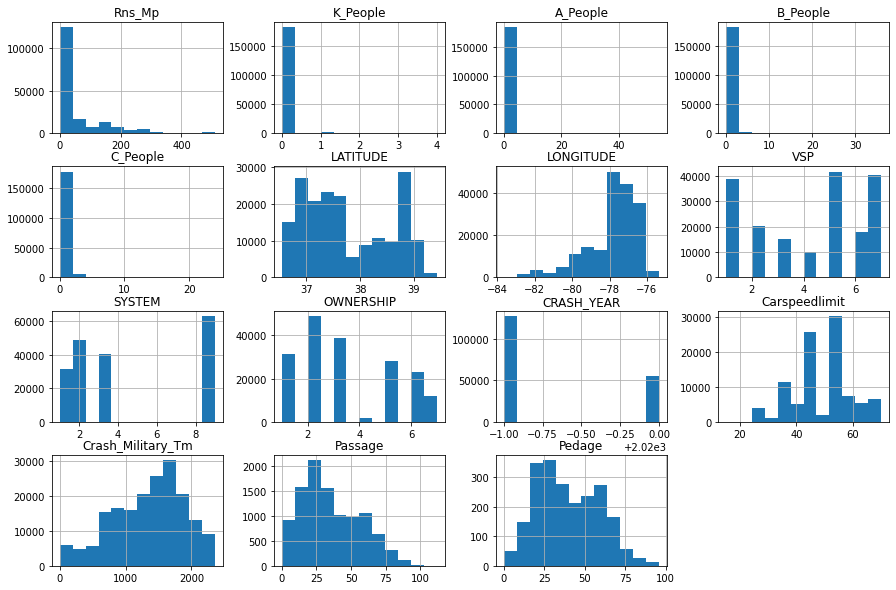

In [9]:
#Distributions of dataset features
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=12, figsize=(15, 10))
plt.show()

In [10]:
# Distribution of classes
dist = df["Crash_Severity"].value_counts(ascending = False) / df["Crash_Severity"].size
pd.DataFrame(dist)

,Crash_Severity
PDO.Property Damage Only,0.666449
B.Visible Injury,0.200783
C.Nonvisible Injury,0.078428
A.Severe Injury,0.047795
K.Fatal Injury,0.006544


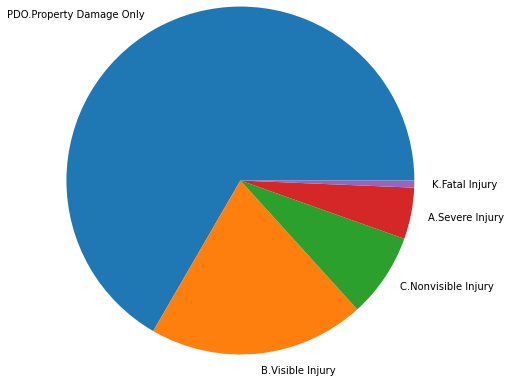

In [11]:
plt.pie(dist, labels = dist.index, radius = 2)
plt.show()

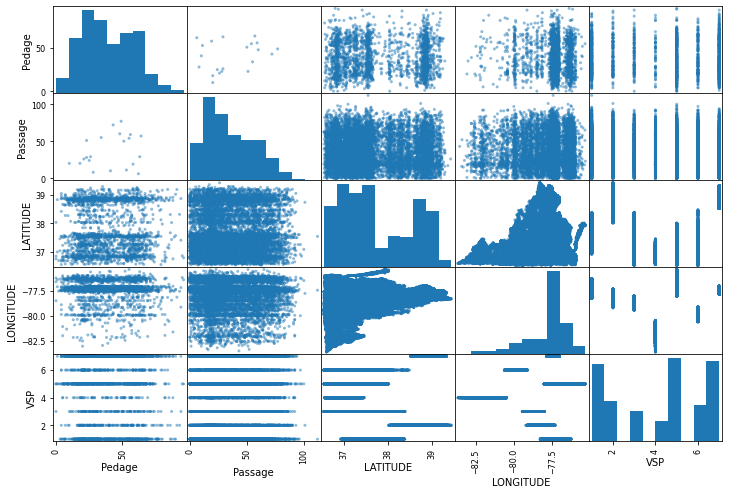

In [12]:
#Scatter matrix of particular features in data
from pandas.plotting import scatter_matrix

attributes = ["Pedage", "Passage", "LATITUDE",
              "LONGITUDE", "VSP"]
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

# Data Cleaning

In [13]:
# A dictionary containing variable names by type
variables = {
        "ordinal" : ["Time_Slicing", "Speed_Notspeed", "Belted_Unbelted", "Alcohol_Notalcohol"],
        "nominal" : ["Weather_Condition", "First_Harmful_Event_of_Entire_C", "Collision_Type", "FAC", "FUN", "Light_Condition", "VDOT_District", "Ownership_Used", "Crash_Event_Type_Dsc", "Roadway_Surface_Cond"],
        "numerical": ["Rns_Mp", "K_People", "A_People", "B_People", "C_People", "LATITUDE", "LONGITUDE", "VSP", "SYSTEM", "OWNERSHIP", "Carspeedlimit", "Crash_Military_Tm"],
        "target": "Crash_Severity"
        }

In [14]:
# Remove any rows with missing values for nominal features
df_nominal = df[variables["nominal"]]
missing = np.array(df_nominal.isna()).any(axis = 1)
indices = np.where(missing)[0]
df.drop(indices, inplace = True)

In [15]:
# Split into X and Y
X = df[variables["ordinal"] + variables["nominal"] + variables["numerical"]]
Y = df[variables["target"]]

In [16]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [17]:
# Reset index
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [18]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (130544, 26)
Y_train: (130544,)
X_test: (32636, 26)
Y_test: (32636,)


In [19]:
pd.Series(Y_train).value_counts().sort_values(ascending = False) / Y_train.size

PDO.Property Damage Only    0.666319
B.Visible Injury            0.203219
C.Nonvisible Injury         0.074672
A.Severe Injury             0.048758
K.Fatal Injury              0.007032
Name: Crash_Severity, dtype: float64

In [20]:
pd.Series(Y_test).value_counts().sort_values(ascending = False) / Y_test.size

PDO.Property Damage Only    0.662826
B.Visible Injury            0.204559
C.Nonvisible Injury         0.077828
A.Severe Injury             0.048076
K.Fatal Injury              0.006710
Name: Crash_Severity, dtype: float64

In [21]:
# Build data transformation pipeline
steps_ordinal = [("encoder", OrdinalEncoder())]
steps_nominal = [("encoder", OneHotEncoder(drop = "first"))]
steps_numerical = [("imputer", SimpleImputer(strategy = "median")), \
                   ("scaler", StandardScaler())]
pipeline_ordinal = Pipeline(steps_ordinal)
pipeline_nominal = Pipeline(steps_nominal)
pipeline_numerical = Pipeline(steps_numerical)

steps_all = [("ordinal", pipeline_ordinal, variables["ordinal"]),
             ("nominal", pipeline_nominal, variables["nominal"]),
             ("numerical", pipeline_numerical, variables["numerical"])]
pipeline = ColumnTransformer(steps_all)

In [22]:
# Pipeline the data
X_train_tr = pipeline.fit_transform(X_train)      # <-- outputs a scipy sparse matrix
X_train_tr = X_train_tr.toarray()                 # <-- convert it to a numpy array
X_test_tr = pipeline.transform(X_test)
X_test_tr = X_test_tr.toarray()

In [23]:
# Label encoding
label_map = {"PDO.Property Damage Only" : 0,
             "C.Nonvisible Injury"      : 1,
             "B.Visible Injury"         : 2,
             "A.Severe Injury"          : 3,
             "K.Fatal Injury"           : 4}
Y_train_tr = Y_train.replace(label_map)
Y_test_tr = Y_test.replace(label_map)

In [24]:
# Compare array shapes before and after encoding
print("X_train:", X_train.shape, "-->", X_train_tr.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "-->", X_test_tr.shape)
print("Y_test:", Y_test.shape)

X_train: (130544, 26) --> (130544, 170)
Y_train: (130544,)
X_test: (32636, 26) --> (32636, 170)
Y_test: (32636,)


In [25]:
# Correlation between target variable and each feature
pd.DataFrame(X_train_tr).corrwith(Y_train_tr).sort_values(ascending = False)

161    0.623168
160    0.441098
159    0.269177
162    0.245187
2      0.232953
         ...   
62    -0.090284
3     -0.094217
53    -0.118350
121   -0.120723
26    -0.120723
Length: 170, dtype: float64

In [26]:
pd.Series(Y_train_tr).value_counts().sort_values(ascending = False) / Y_train_tr.size

0    0.666319
2    0.203219
1    0.074672
3    0.048758
4    0.007032
Name: Crash_Severity, dtype: float64

In [27]:
pd.Series(Y_test_tr).value_counts().sort_values(ascending = False) / Y_test_tr.size

0    0.662826
2    0.204559
1    0.077828
3    0.048076
4    0.006710
Name: Crash_Severity, dtype: float64

# Dimensionality Reduction

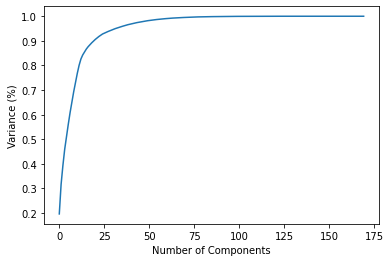

In [28]:
# Visualize PCA for various numbers of principal components
pca = PCA()
pca.fit(X_train_tr)
pca_variances = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pca_variances)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()

In [29]:
# Apply PCA to the data
n_pc = np.where(pca_variances >= 0.99)[0][0] + 1    # preserve 99% of variance in the dataset
pca = PCA(n_components = n_pc)
X_train_pca = pca.fit_transform(X_train_tr)
X_test_pca = pca.transform(X_test_tr)

In [30]:
# Compare array shapes before and after PCA
print("X_train:", X_train_tr.shape, "-->", X_train_pca.shape)
print("Y_train:", Y_train_tr.shape)
print("X_test:", X_test_tr.shape, "-->", X_test_pca.shape)
print("Y_test:", Y_test_tr.shape)

X_train: (130544, 170) --> (130544, 60)
Y_train: (130544,)
X_test: (32636, 170) --> (32636, 60)
Y_test: (32636,)


# Model Training & Predicting

In [31]:
# Number of classes
n_classes = np.unique(Y_train_tr).size
n_classes

5

In [32]:
model = LogisticRegression()
model.fit(X_train_pca, Y_train_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# Make predictions
Y_train_pred = model.predict(X_train_pca)
Y_test_pred = model.predict(X_test_pca)

# Model Results

In [34]:
# Confusion matrix for training set
pd.DataFrame(confusion_matrix(Y_train_pred, Y_train_tr))

,0,1,2,3,4
0,86984,0,0,0,0
1,0,9748,1,0,0
2,0,0,26528,0,0
3,0,0,0,6365,0
4,0,0,0,0,918


In [35]:
# Confusion matrix for testing set
pd.DataFrame(confusion_matrix(Y_test_pred, Y_test_tr))

,0,1,2,3,4
0,21632,0,0,0,0
1,0,2540,0,0,0
2,0,0,6676,0,0
3,0,0,0,1569,0
4,0,0,0,0,219


In [36]:
# Calculate metrics for training set
acc_train = accuracy_score(Y_train_tr, Y_train_pred)
prec_train = precision_score(Y_train_tr, Y_train_pred, average = None)
recall_train = recall_score(Y_train_tr, Y_train_pred, average = None)
f1_train = f1_score(Y_train_tr, Y_train_pred, average = None)

# Calculate metrics for testing set
acc_test = accuracy_score(Y_test_tr, Y_test_pred)
prec_test = precision_score(Y_test_tr, Y_test_pred, average = None)
recall_test = recall_score(Y_test_tr, Y_test_pred, average = None)
f1_test = f1_score(Y_test_tr, Y_test_pred, average = None)

In [37]:
# Create dataframe
metrics_train = np.array([acc_train, \
                          prec_train[0], prec_train[1], prec_train[2], prec_train[3], prec_train[4], \
                          recall_train[0], recall_train[1], recall_train[2], recall_train[3], recall_train[4], \
                          f1_train[0], f1_train[1], f1_train[2], f1_train[3], f1_train[4]])

metrics_test = np.array([acc_test, \
                         prec_test[0], prec_test[1], prec_test[2], prec_test[3], prec_test[4], \
                         recall_test[0], recall_test[1], recall_test[2], recall_test[3], recall_test[4], \
                         f1_test[0], f1_test[1], f1_test[2], f1_test[3], f1_test[4]])

metrics = {"Training Set": metrics_train, "Testing Set": metrics_test}
metrics = pd.DataFrame(metrics)
metrics.index = ["Accuracy", \
                 "Precision (Class 0)", "Precision (Class 1)", "Precision (Class 2)", "Precision (Class 3)", "Precision (Class 4)", \
                 "Recall (Class 0)", "Recall (Class 1)", "Recall (Class 2)", "Recall (Class 3)", "Recall (Class 4)", \
                 "F1 Score (Class 0)", "F1 Score (Class 1)", "F1 Score (Class 2)", "F1 Score (Class 3)", "F1 Score (Class 4)"]

In [38]:
# Display metrics
metrics

,Training Set,Testing Set
Accuracy,0.999992,1.0
Precision (Class 0),1.000000,1.0
Precision (Class 1),0.999897,1.0
Precision (Class 2),1.000000,1.0
Precision (Class 3),1.000000,1.0
Precision (Class 4),1.000000,1.0
Recall (Class 0),1.000000,1.0
Recall (Class 1),1.000000,1.0
Recall (Class 2),0.999962,1.0
Recall (Class 3),1.000000,1.0
